In [23]:
# Новый анализ: трубопроводное оборудование и факторы коррозии
# Ячейка 1: Импорты и конфигурация
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Путь к src для импорта функций загрузки
if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data

# Настройки визуализации
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 140)

print('Библиотеки загружены, окружение готово')


Библиотеки загружены, окружение готово


In [37]:
# Ячейка 2: Загрузка данных и первичная проверка

df_raw = load_corrosion_data()
print(f"Загружено записей: {len(df_raw):,}; колонок: {len(df_raw.columns)}")

# Ключевые опорные колонки (если есть)
key_cols = [c for c in ['component_type_id','component_type_name','corrosion_rate',
                        'start_date_of_operation'] if c in df_raw.columns]
print('Опорные колонки:', key_cols)

# Выявим числовые столбцы
numeric_cols = [c for c in df_raw.columns if pd.api.types.is_numeric_dtype(df_raw[c])]
print(f"Числовые признаки: {len(numeric_cols)}")

# Копия для работы
df = df_raw.copy()


Загружено записей: 442,052; колонок: 64
Опорные колонки: ['component_type_id', 'component_type_name', 'corrosion_rate', 'start_date_of_operation']
Числовые признаки: 49


In [38]:
# Ячейка 3: Очистка данных (деликатная)
print('Очистка данных...')

# 1) Сохранить только записи со скоростью коррозии
before = len(df)
df = df[df['corrosion_rate'].notna()].copy()
print(f"Удалено без corrosion_rate: {before - len(df):,}")

# 2) Физически осмысленные границы
before = len(df)
df = df[(df['corrosion_rate'] >= 0) & (df['corrosion_rate'] <= 10)].copy()
print(f"Удалено выбросов по corrosion_rate: {before - len(df):,}")

# 3) Не заполняем NaN нулями по химии — это искажает вариацию.
#    Пусть NaN остаются, т.к. при корреляциях они будут аккуратно удаляться.

# 4) Контроль типов
for c in numeric_cols:
    # Принудительно к числу там, где возможно
    df[c] = pd.to_numeric(df[c], errors='coerce')

print(f"Итоговый размер: {len(df):,}")


Очистка данных...
Удалено без corrosion_rate: 128,859
Удалено выбросов по corrosion_rate: 61
Итоговый размер: 313,132


In [39]:
# Ячейка 4: Группировка признаков
feature_groups = {
    'ГЕОМЕТРИЧЕСКИЕ': [
        'component_type_id','wall_thickness','outer_diameter','inner_diameter',
        'diameter_to_thickness_ratio','cross_sectional_area','radius'
    ],
    'ОПЕРАЦИОННЫЕ': [
        'operating_temperature','operating_pressure'
    ],
    'ХИМИЧЕСКИЕ_ОСНОВНЫЕ': [
        'water_content','h2s_content','sulfur_content','chlorine_content','co2_content','oxygen_content'
    ],
    'ХИМИЧЕСКИЕ_УГЛЕВОДОРОДЫ': [
        'methane_content','ethane_content','propane_content','butane_content','propylene_content','ethylene_content'
    ],
    'ХИМИЧЕСКИЕ_КИСЛОТЫ': [
        'sulfuric_acid_content','hydrochloric_acid_content','acetic_acid_content','naphthenic_acid_content'
    ],
    'АГРЕГАТНЫЕ': [
        'total_sulfur_compounds','total_chlorine_compounds','total_acids'
    ],
    'МАТЕРИАЛЫ': [
        'material_resistance_score'
    ]
}

# Оставляем только существующие
actual_groups = {}
for g, cols in feature_groups.items():
    present = [c for c in cols if c in df.columns]
    if present:
        actual_groups[g] = present

print('Доступные группы и число признаков:')
for g, cols in actual_groups.items():
    print(f"  {g}: {len(cols)}")


Доступные группы и число признаков:
  ГЕОМЕТРИЧЕСКИЕ: 7
  ОПЕРАЦИОННЫЕ: 2
  ХИМИЧЕСКИЕ_ОСНОВНЫЕ: 6
  ХИМИЧЕСКИЕ_УГЛЕВОДОРОДЫ: 6
  ХИМИЧЕСКИЕ_КИСЛОТЫ: 4
  АГРЕГАТНЫЕ: 3
  МАТЕРИАЛЫ: 1


In [40]:
# Ячейка 5: Диагностика качества данных

report_rows = []
for g, cols in actual_groups.items():
    for c in cols:
        s = df[c]
        n = len(s)
        n_na = s.isna().sum()
        nunique = s.nunique(dropna=True)
        std = s.std(skipna=True)
        zero_var = (std == 0) or (nunique <= 1)
        report_rows.append({
            'group': g,
            'column': c,
            'count': n,
            'missing_pct': n_na / n * 100,
            'nunique': nunique,
            'std': std,
            'zero_variance': bool(zero_var)
        })

quality_df = pd.DataFrame(report_rows).sort_values(['group','zero_variance','missing_pct'], ascending=[True, False, False])
print('Первые 20 строк отчета по качеству:')
quality_df.head(20)


Первые 20 строк отчета по качеству:


,group,column,count,missing_pct,nunique,std,zero_variance
27,АГРЕГАТНЫЕ,total_acids,313132,0.273048,1,0.000000,True
25,АГРЕГАТНЫЕ,total_sulfur_compounds,313132,0.273048,182,1.259570,False
26,АГРЕГАТНЫЕ,total_chlorine_compounds,313132,0.273048,14,0.462422,False
4,ГЕОМЕТРИЧЕСКИЕ,diameter_to_thickness_ratio,313132,0.008942,204,5.963119,False
0,ГЕОМЕТРИЧЕСКИЕ,component_type_id,313132,0.000000,7,0.611533,False
1,ГЕОМЕТРИЧЕСКИЕ,wall_thickness,313132,0.000000,58,4.789153,False
2,ГЕОМЕТРИЧЕСКИЕ,outer_diameter,313132,0.000000,61,132.119145,False
3,ГЕОМЕТРИЧЕСКИЕ,inner_diameter,313132,0.000000,198,128.506783,False
5,ГЕОМЕТРИЧЕСКИЕ,cross_sectional_area,313132,0.000000,216,4586.996450,False
6,ГЕОМЕТРИЧЕСКИЕ,radius,313132,0.000000,61,66.059572,False


In [41]:
# Ячейка 6: Безопасные корреляции (Pearson и Spearman)

TARGET = 'corrosion_rate'

def safe_pearson(x: pd.Series, y: pd.Series) -> float:
    mask = x.notna() & y.notna()
    x1 = x[mask].astype(float)
    y1 = y[mask].astype(float)
    if len(x1) < 3:
        return np.nan
    if x1.std() == 0 or y1.std() == 0:
        return np.nan
    return np.corrcoef(x1, y1)[0, 1]

def safe_spearman(x: pd.Series, y: pd.Series) -> float:
    mask = x.notna() & y.notna()
    x1 = x[mask].astype(float)
    y1 = y[mask].astype(float)
    if len(x1) < 3:
        return np.nan
    # ранги и Pearson над ними
    xr = x1.rank(method='average')
    yr = y1.rank(method='average')
    if xr.std() == 0 or yr.std() == 0:
        return np.nan
    return np.corrcoef(xr, yr)[0, 1]

print('Функции корреляций готовы')


Функции корреляций готовы


In [42]:
# Ячейка 7: Корреляции признаков с целью

corr_rows = []
for g, cols in actual_groups.items():
    for c in cols:
        if c == TARGET or c not in df.columns:
            continue
        s = df[c]
        # исключим заведомо проблемные
        if s.nunique(dropna=True) <= 1:
            continue
        pear = safe_pearson(s, df[TARGET])
        spear = safe_spearman(s, df[TARGET])
        corr_rows.append({'group': g, 'feature': c, 'pearson': pear, 'spearman': spear})

corr_df = pd.DataFrame(corr_rows)

# Отсортируем по |Spearman| как более устойчивой метрике для монотонных связей
corr_sorted = corr_df.dropna(subset=['spearman']).copy()
corr_sorted['abs_spearman'] = corr_sorted['spearman'].abs()
corr_sorted = corr_sorted.sort_values('abs_spearman', ascending=False)

print('ТОП-20 признаков по |Spearman| корреляции:')
print(corr_sorted.head(20)[['group','feature','pearson','spearman']].to_string(index=False))


ТОП-20 признаков по |Spearman| корреляции:
                  group                     feature   pearson  spearman
         ГЕОМЕТРИЧЕСКИЕ              wall_thickness  0.097318  0.122481
         ГЕОМЕТРИЧЕСКИЕ        cross_sectional_area  0.058584  0.120676
         ГЕОМЕТРИЧЕСКИЕ                      radius  0.056071  0.111079
         ГЕОМЕТРИЧЕСКИЕ              outer_diameter  0.056071  0.111079
         ГЕОМЕТРИЧЕСКИЕ              inner_diameter  0.054020  0.103861
         ГЕОМЕТРИЧЕСКИЕ diameter_to_thickness_ratio  0.034644  0.085357
             АГРЕГАТНЫЕ      total_sulfur_compounds  0.070061  0.083886
    ХИМИЧЕСКИЕ_ОСНОВНЫЕ                 h2s_content  0.019176  0.069903
             АГРЕГАТНЫЕ    total_chlorine_compounds -0.003079  0.059788
    ХИМИЧЕСКИЕ_ОСНОВНЫЕ              sulfur_content  0.065621  0.057403
           ОПЕРАЦИОННЫЕ       operating_temperature  0.081708  0.053528
    ХИМИЧЕСКИЕ_ОСНОВНЫЕ              oxygen_content -0.053345 -0.052969
     ХИМИЧЕСКИЕ_КИСЛО

In [43]:
# Ячейка 8: Топ-факторы по группам

print('Топ-факторы по группам (по |Spearman|):')
for g in actual_groups.keys():
    tmp = corr_sorted[corr_sorted['group'] == g]
    if len(tmp) == 0:
        continue
    head = tmp.head(5)[['feature','pearson','spearman']]
    print(f"\n{g}:")
    print(head.to_string(index=False))


Топ-факторы по группам (по |Spearman|):

ГЕОМЕТРИЧЕСКИЕ:
             feature  pearson  spearman
      wall_thickness 0.097318  0.122481
cross_sectional_area 0.058584  0.120676
              radius 0.056071  0.111079
      outer_diameter 0.056071  0.111079
      inner_diameter 0.054020  0.103861

ОПЕРАЦИОННЫЕ:
              feature  pearson  spearman
operating_temperature 0.081708  0.053528
   operating_pressure 0.006772  0.036001

ХИМИЧЕСКИЕ_ОСНОВНЫЕ:
         feature   pearson  spearman
     h2s_content  0.019176  0.069903
  sulfur_content  0.065621  0.057403
  oxygen_content -0.053345 -0.052969
   water_content -0.035710 -0.033894
chlorine_content  0.023065  0.009882

ХИМИЧЕСКИЕ_УГЛЕВОДОРОДЫ:
          feature   pearson  spearman
   butane_content -0.022967  0.044360
  propane_content  0.003719  0.039878
   ethane_content -0.007424  0.037768
  methane_content -0.019423  0.015643
propylene_content -0.036772  0.009959

ХИМИЧЕСКИЕ_КИСЛОТЫ:
                  feature   pearson  spearman


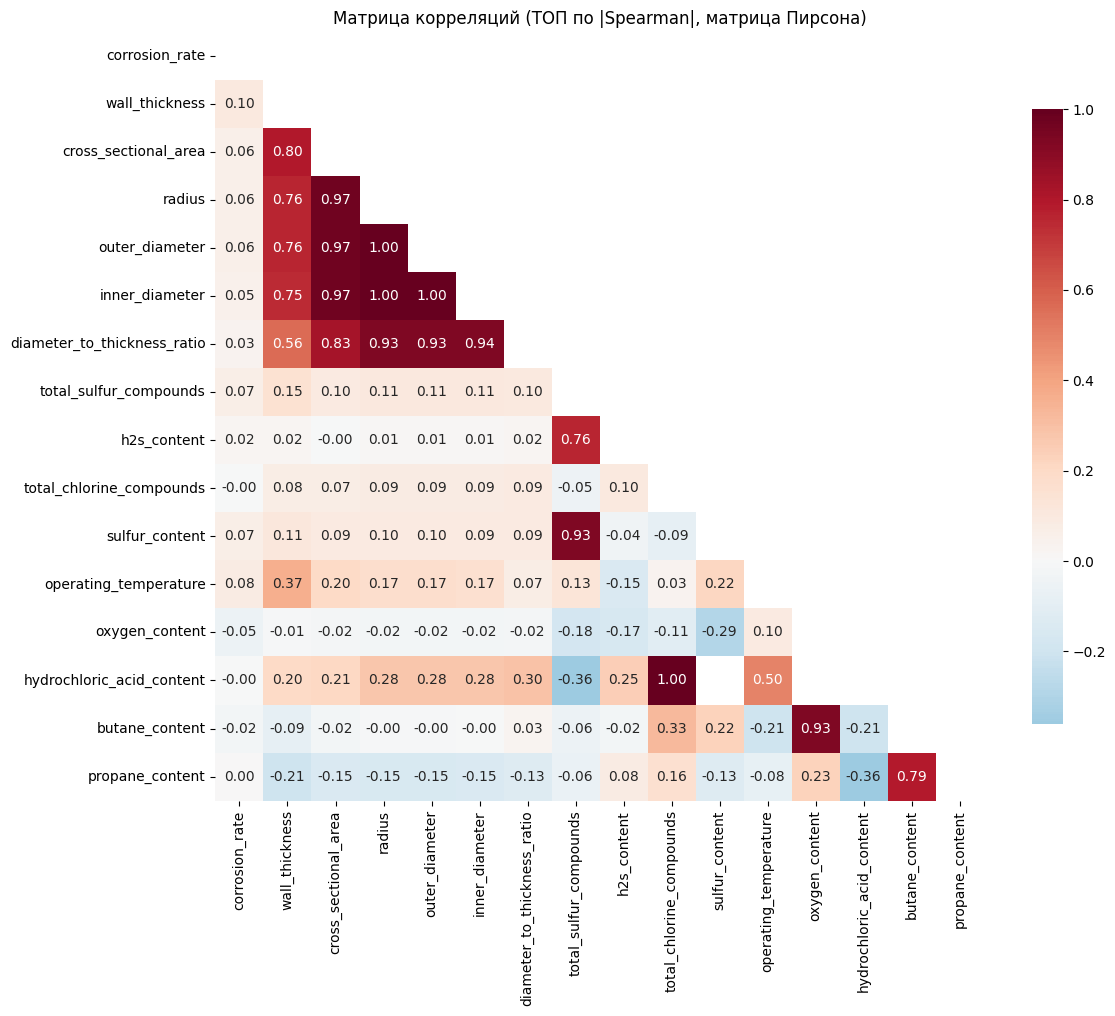

In [44]:
# Ячейка 9: Визуализация — матрица корреляций по топ-признакам

# Возьмем до 15 лучших признаков по |Spearman|
TOP_N = 15
top_features = corr_sorted.head(TOP_N)['feature'].tolist()
cols_for_matrix = [TARGET] + top_features

corr_mat = df[cols_for_matrix].corr(method='pearson')  # строим матрицу Пирсона

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций (ТОП по |Spearman|, матрица Пирсона)')
plt.tight_layout()
plt.show()


Сегментация по component_type_name:
Выбраны типы (>=1000 записей): 5

Топ-корреляции внутри крупнейших типов:


,type,feature,pearson,spearman,n
48,Неизвестный,total_chlorine_compounds,0.112596,0.043676,2039
45,Неизвестный,diameter_to_thickness_ratio,0.001784,0.011686,2039
44,Неизвестный,inner_diameter,0.004800,0.009044,2039
42,Неизвестный,radius,0.006154,-0.003936,2039
43,Неизвестный,outer_diameter,0.006154,-0.003936,2039
10,Отвод,wall_thickness,0.129943,0.118538,82914
16,Отвод,total_sulfur_compounds,0.064450,0.110686,82914
11,Отвод,cross_sectional_area,0.070725,0.076139,82914
19,Отвод,sulfur_content,0.062923,0.075939,82914
17,Отвод,h2s_content,-0.020248,0.060438,82914


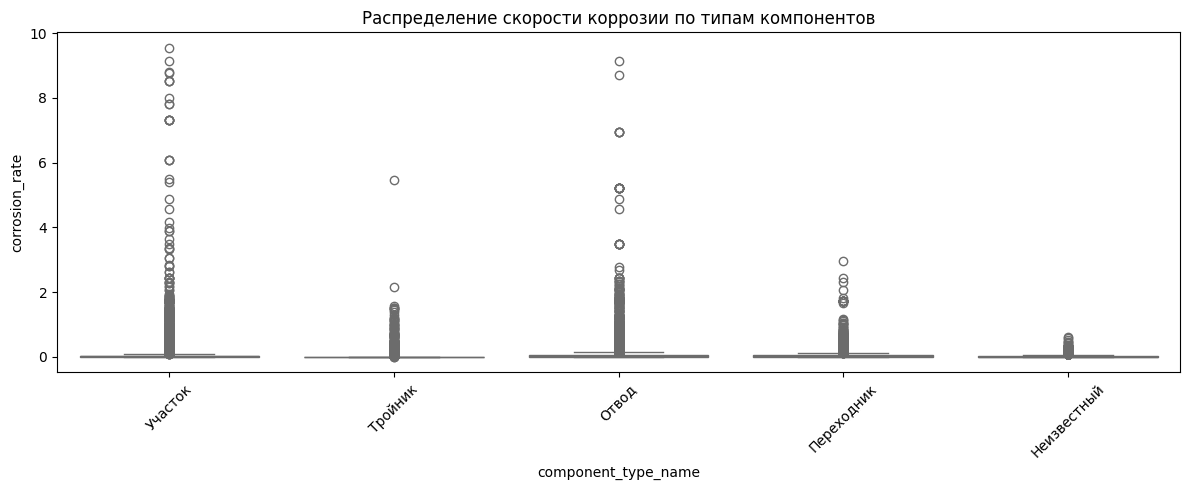

In [45]:
# Ячейка 10: Сегментация по типам компонентов

if 'component_type_name' in df.columns:
    print('Сегментация по component_type_name:')
    type_counts = df['component_type_name'].value_counts()
    major_types = type_counts[type_counts >= 1000].index.tolist()
    print(f"Выбраны типы (>=1000 записей): {len(major_types)}")

    seg_rows = []
    for t in major_types:
        seg = df[df['component_type_name'] == t]
        for f in top_features[:10]:
            pear = safe_pearson(seg[f], seg[TARGET]) if f in seg.columns else np.nan
            spear = safe_spearman(seg[f], seg[TARGET]) if f in seg.columns else np.nan
            seg_rows.append({'type': t, 'feature': f, 'pearson': pear, 'spearman': spear, 'n': len(seg)})
    seg_df = pd.DataFrame(seg_rows)

    print('\nТоп-корреляции внутри крупнейших типов:')
    display(seg_df.sort_values(['type','spearman'], ascending=[True, False]).groupby('type').head(5))

    # Визуализация распределения corrosion_rate по типам
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df[df['component_type_name'].isin(major_types)], x='component_type_name', y=TARGET)
    plt.title('Распределение скорости коррозии по типам компонентов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Колонка component_type_name отсутствует — сегментацию пропускаем')


In [46]:
# Ячейка 11: Итоговые таблицы и экспорт

out_dir = '../data'
os.makedirs(out_dir, exist_ok=True)

# Основная таблица корреляций
corr_export = corr_sorted[['group','feature','pearson','spearman']]
corr_path = os.path.join(out_dir, 'correlations_features_vs_corrosion.csv')
corr_export.to_csv(corr_path, index=False, encoding='utf-8')
print(f"Сохранено: {corr_path}")

# Таблица качества данных
quality_path = os.path.join(out_dir, 'feature_quality_report.csv')
quality_df.to_csv(quality_path, index=False, encoding='utf-8')
print(f"Сохранено: {quality_path}")

print('\nКлючевые инсайты:')
# 1) Топ общих факторов
print('— ТОП-10 факторов (по |Spearman|):')
print(corr_sorted.head(10)[['group','feature','spearman']].to_string(index=False))

# 2) Геометрические факторы
if 'ГЕОМЕТРИЧЕСКИЕ' in actual_groups:
    geo = corr_sorted[corr_sorted['group'] == 'ГЕОМЕТРИЧЕСКИЕ'].head(5)
    print('\n— Геометрия (ТОП-5):')
    print(geo[['feature','spearman']].to_string(index=False))

print('\nАнализ завершен.')


Сохранено: ../data\correlations_features_vs_corrosion.csv
Сохранено: ../data\feature_quality_report.csv

Ключевые инсайты:
— ТОП-10 факторов (по |Spearman|):
              group                     feature  spearman
     ГЕОМЕТРИЧЕСКИЕ              wall_thickness  0.122481
     ГЕОМЕТРИЧЕСКИЕ        cross_sectional_area  0.120676
     ГЕОМЕТРИЧЕСКИЕ                      radius  0.111079
     ГЕОМЕТРИЧЕСКИЕ              outer_diameter  0.111079
     ГЕОМЕТРИЧЕСКИЕ              inner_diameter  0.103861
     ГЕОМЕТРИЧЕСКИЕ diameter_to_thickness_ratio  0.085357
         АГРЕГАТНЫЕ      total_sulfur_compounds  0.083886
ХИМИЧЕСКИЕ_ОСНОВНЫЕ                 h2s_content  0.069903
         АГРЕГАТНЫЕ    total_chlorine_compounds  0.059788
ХИМИЧЕСКИЕ_ОСНОВНЫЕ              sulfur_content  0.057403

— Геометрия (ТОП-5):
             feature  spearman
      wall_thickness  0.122481
cross_sectional_area  0.120676
              radius  0.111079
      outer_diameter  0.111079
      inner_diameter  0.103